In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional


2024-12-18 12:14:00.778522: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from sklearn.model_selection import train_test_split

# # Simulated dataset: 100 sequences, 32 steps per sequence, 3 drum types
# num_samples = 100
# sequence_length = 32
# num_drums = 3

# # Random binary drum patterns
# data = np.random.randint(2, size=(num_samples, sequence_length, num_drums))

# # Split into input (X) and output (y)
# X = data[:, :-1, :]  # All steps except the last
# y = data[:, 1:, :]   # All steps except the first

num_samples = 1000
sequence_length = 32
num_drums = 3

# Generate structured drum patterns
data = np.zeros((num_samples, sequence_length, num_drums))

for seq in data:
    for t in range(sequence_length):
        # Kick drum pattern (36 - MIDI pitch)
        if t % 4 == 0:  # Strong beats (1, 2, 3, 4 in 4/4 time)
            seq[t, 0] = 1
        elif np.random.rand() < 0.3:  # 20% chance of offbeat kick
            seq[t, 0] = 1
        
        # Snare drum pattern (38 - MIDI pitch)
        if t % 4 == 2:  # Backbeats (2, 4 in 4/4 time)
            seq[t, 1] = 1
        elif np.random.rand() < 0.2:  # 10% chance of ghost note
            seq[t, 1] = 1

        # Hi-hat pattern (42 - MIDI pitch)
        if t % 2 == 0:  # Every 8th note
            seq[t, 2] = 1
        elif np.random.rand() < 0.1:  # 5% chance of an open hi-hat
            seq[t, 2] = 1

shift = np.random.randint(-1, 2)  # Shift hits by -1, 0, or +1 timestep
data = np.roll(data, shift=shift, axis=1)

# Split into input (X) and output (y)
X = data[:, :-1, :]
y = data[:, 1:, :]

# Define the split sizes
test_size = 0.2  # 20% for the test set
val_size = 0.25  # 25% of the remaining data for validation (20% of original)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Split train set further into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42)

# Print the sizes of each split
print(f"Training data: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation data: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test data: X_test: {X_test.shape}, y_test: {y_test.shape}")

# Convert training data to tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Shuffle, batch, and prefetch the dataset
batch_size = 16
train_loader = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)


Training data: X_train: (600, 31, 3), y_train: (600, 31, 3)
Validation data: X_val: (200, 31, 3), y_val: (200, 31, 3)
Test data: X_test: (200, 31, 3), y_test: (200, 31, 3)


In [3]:
print(f"Train Hit Ratio: {np.sum(y_train) / np.prod(y_train.shape):.4f}")
print(f"Validation Hit Ratio: {np.sum(y_val) / np.prod(y_val.shape):.4f}")


Train Hit Ratio: 0.4833
Validation Hit Ratio: 0.4842


In [4]:
from tensorflow.keras.layers import Attention, Input, Conv1D, Dropout, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall

# Define the input layer
input_layer = Input(shape=(sequence_length - 1, num_drums))

# Add a convolutional layer
conv_output = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)

# Add a Bidirectional LSTM layer
lstm_output = Bidirectional(LSTM(128, return_sequences=True))(conv_output)

# Add a dropout layer
lstm_output = Dropout(0.1)(lstm_output)

# Add an attention layer
attention = Attention()([lstm_output, lstm_output])

# Add a dense output layer
output_layer = Dense(num_drums, activation='softmax')(attention)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
from tensorflow.keras.metrics import Precision, Recall

# Compile the model with precision and recall
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,                    # Training data
    epochs=20,                           # Number of epochs
    batch_size=16,                       # Batch size
    validation_data=(X_val, y_val),      # Validation data
    verbose=1                            # Display progress
)


2024-12-18 12:14:21.245758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-18 12:14:21.248381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-18 12:14:21.249978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 31, 3)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 31, 64)       640         ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 31, 256)      197632      ['conv1d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 31, 256)      0           ['bidirectional[0][0]']          
                                                                                              

2024-12-18 12:14:22.340508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-18 12:14:22.342997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-18 12:14:22.344837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

37/38 [============================>.] - ETA: 0s - loss: 0.6839 - accuracy: 0.0455 - precision: 0.5673 - recall: 0.0296

2024-12-18 12:14:29.616895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-18 12:14:29.619147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-18 12:14:29.620855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 [==============================] - 9s 74ms/step - loss: 0.6838 - accuracy: 0.0467 - precision: 0.5673 - recall: 0.0292 - val_loss: 0.6807 - val_accuracy: 0.0456 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
38/38 [==============================] - 2s 41ms/step - loss: 0.6764 - accuracy: 0.1462 - precision: 0.6334 - recall: 0.0318 - val_loss: 0.6714 - val_accuracy: 0.1516 - val_precision: 0.6307 - val_recall: 0.0597
Epoch 3/20
38/38 [==============================] - 1s 38ms/step - loss: 0.6264 - accuracy: 0.2978 - precision: 0.7207 - recall: 0.1599 - val_loss: 0.4590 - val_accuracy: 0.6423 - val_precision: 0.8631 - val_recall: 0.3759
Epoch 4/20
38/38 [==============================] - 2s 48ms/step - loss: 0.1679 - accuracy: 0.5071 - precision: 0.8071 - recall: 0.4973 - val_loss: 0.0724 - val_accuracy: 0.4689 - val_precision: 0.8287 - val_recall: 0.5123
Epoch 5/20
38/38 [==============================] - 2s 43ms/step - loss: 0.0410 - accuracy: 0.5138 - precision:

In [221]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred_binary = (model.predict(X) > 0.5).astype(int)
print("Precision:", precision_score(y.flatten(), y_pred_binary.flatten()))
print("Recall:", recall_score(y.flatten(), y_pred_binary.flatten()))
print("F1 Score:", f1_score(y.flatten(), y_pred_binary.flatten()))


2024-12-11 12:46:29.097230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-11 12:46:29.100310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-11 12:46:29.103173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/32 [..............................] - ETA: 35s

2024-12-11 12:46:29.677453: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 6291456 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


32/32 [==============================] - 2s 20ms/step
Precision: 0.9253074176913924
Recall: 0.519949179743224
F1 Score: 0.6657818877186974


In [5]:
thresholds = [0.3, 0.4, 0.5, 0.6]
for threshold in thresholds:
    y_pred_binary = (model.predict(X_train) > threshold).astype(int)
    accuracy = np.mean((y_train == y_pred_binary).astype(int))
    print(f"Threshold: {threshold}, Accuracy: {accuracy:.4f}")


2024-12-18 12:15:00.424118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-18 12:15:00.426272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-18 12:15:00.428174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/19 [>.............................] - ETA: 16s

2024-12-18 12:15:00.904983: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 6291456 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


19/19 [==============================] - 1s 23ms/step
Threshold: 0.3, Accuracy: 0.6666
19/19 [==============================] - 1s 26ms/step
Threshold: 0.4, Accuracy: 0.7086
19/19 [==============================] - 0s 23ms/step
Threshold: 0.5, Accuracy: 0.7468
19/19 [==============================] - 1s 31ms/step
Threshold: 0.6, Accuracy: 0.7447


In [6]:
for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
    y_pred_batch = model.predict(X_batch)
    batch_accuracy = np.mean((y_pred_batch > 0.5) == y_batch)
    print(f"Batch {batch_idx + 1}: Accuracy = {batch_accuracy:.4f}")


2024-12-18 12:15:03.338740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [600,31,3]
	 [[{{node Placeholder/_0}}]]
2024-12-18 12:15:03.339250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [600,31,3]
	 [[{{node Placeholder/_1}}]]
2024-12-18 12:15:03.774113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/spl

1/1 [==============================] - 1s 1s/step
Batch 1: Accuracy = 0.7426
1/1 [==============================] - 0s 61ms/step
Batch 2: Accuracy = 0.7366
1/1 [==============================] - 0s 40ms/step
Batch 3: Accuracy = 0.7466
1/1 [==============================] - 0s 32ms/step
Batch 4: Accuracy = 0.7325
1/1 [==============================] - 0s 48ms/step
Batch 5: Accuracy = 0.7567
1/1 [==============================] - 0s 44ms/step
Batch 6: Accuracy = 0.7191
1/1 [==============================] - 0s 47ms/step
Batch 7: Accuracy = 0.7399
1/1 [==============================] - 0s 44ms/step
Batch 8: Accuracy = 0.7426
1/1 [==============================] - 0s 32ms/step
Batch 9: Accuracy = 0.7513
1/1 [==============================] - 0s 44ms/step
Batch 10: Accuracy = 0.7466
1/1 [==============================] - 0s 46ms/step
Batch 11: Accuracy = 0.7567
1/1 [==============================] - 0s 70ms/step
Batch 12: Accuracy = 0.7547
1/1 [==============================] - 0s 55ms/step

1/1 [==============================] - 0s 32ms/step


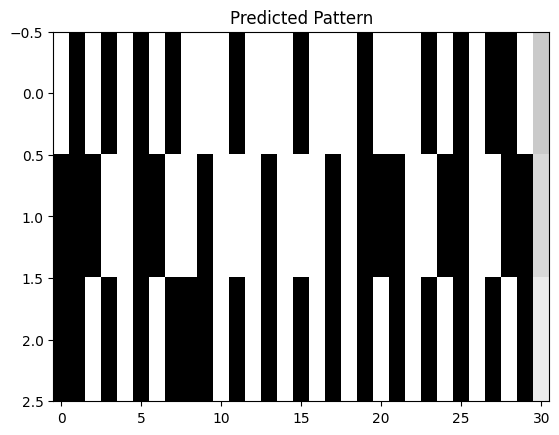

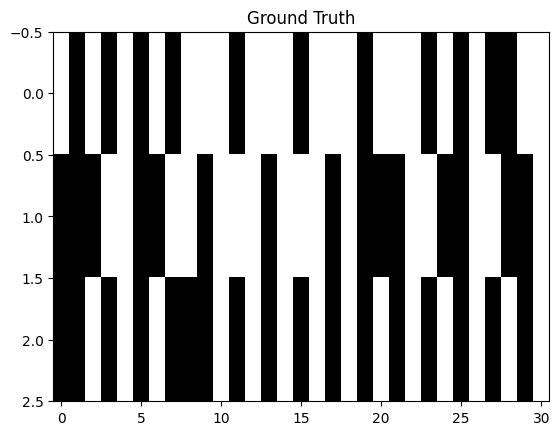

In [133]:
import matplotlib.pyplot as plt

y_pred = model.predict(X[:5])
plt.imshow(y_pred[0].T, cmap='binary', aspect='auto')
plt.title("Predicted Pattern")
plt.show()

plt.imshow(y[0].T, cmap='binary', aspect='auto')
plt.title("Ground Truth")
plt.show()


1/1 [==============================] - 0s 32ms/step


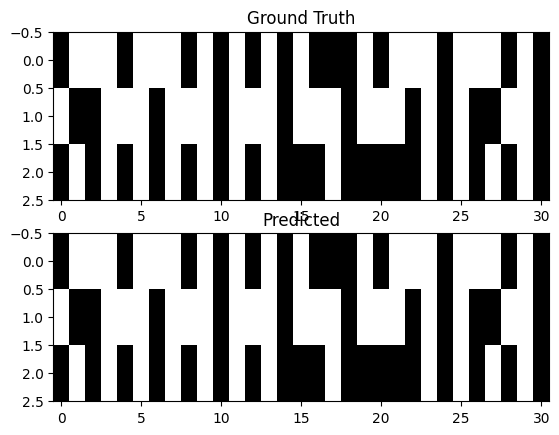

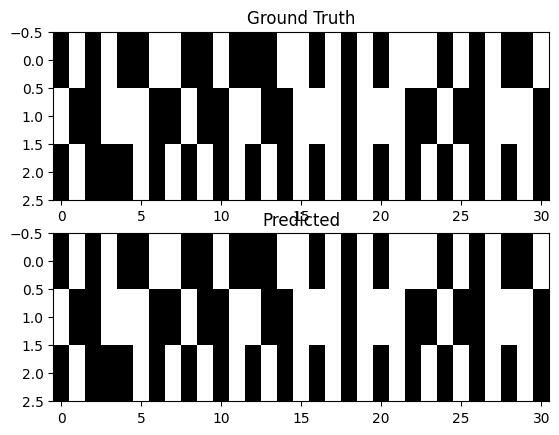

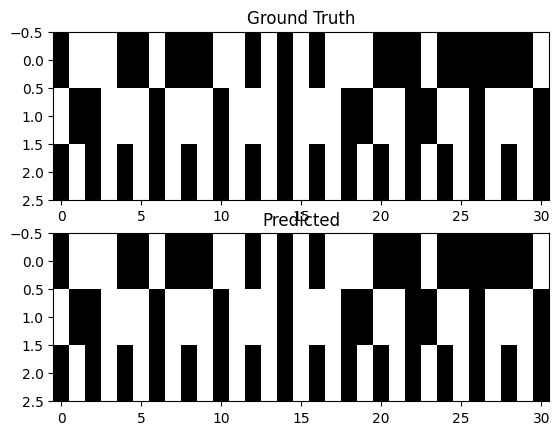

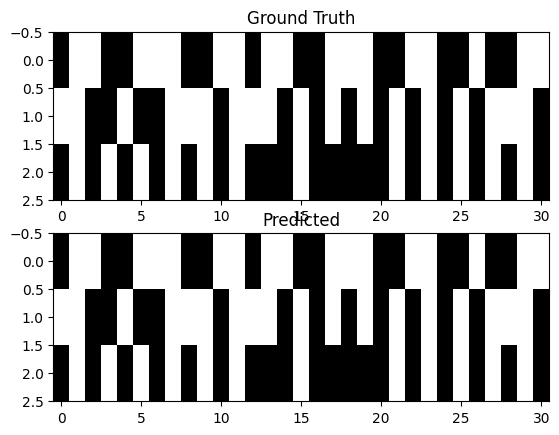

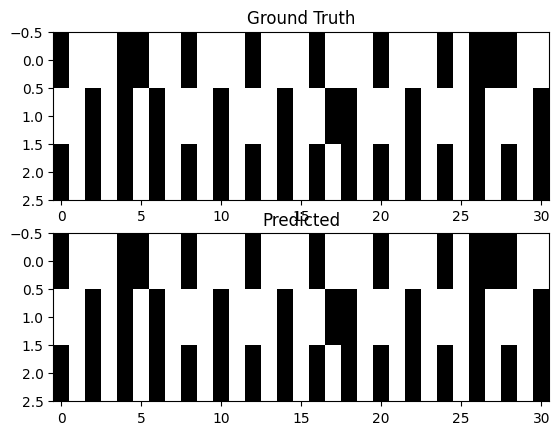

In [118]:
import matplotlib.pyplot as plt

# Compare predictions with ground truth
y_pred = model.predict(X[:5])

for i in range(5):
    plt.subplot(2, 1, 1)
    plt.imshow(y[i].T, cmap='binary', aspect='auto')
    plt.title('Ground Truth')

    plt.subplot(2, 1, 2)
    plt.imshow(y_pred[i].T > 0.5, cmap='binary', aspect='auto')
    plt.title('Predicted')
    plt.show()


In [8]:
from sklearn.metrics import f1_score

y_val_pred = model.predict(X_val)
print("Validation F1-Score:", f1_score(y_val.flatten(), (y_val_pred > 0.5).flatten()))


7/7 [==============================] - 0s 27ms/step
Validation F1-Score: 0.6652391149179158


1/1 [==============================] - 0s 38ms/step
Raw predictions for the next step:
[0.05556069 0.13396552 0.38053212]


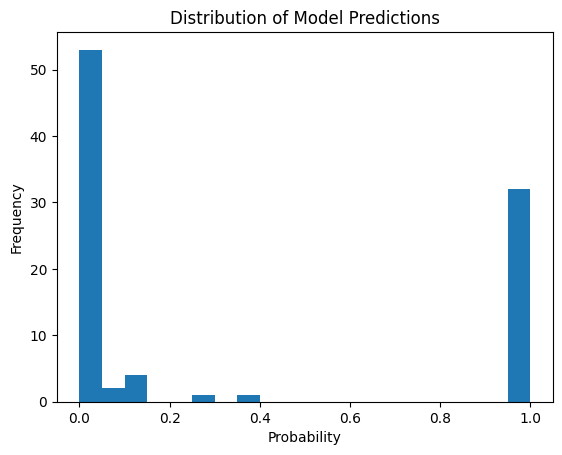

In [135]:
# Example prediction for a single sequence
prediction = model.predict(generated_sequence[:, -sequence_length + 1:, :])
print("Raw predictions for the next step:")
print(prediction[0, -1, :])  # Output for the last timestep

# Visualize the distribution
import matplotlib.pyplot as plt
plt.hist(prediction.flatten(), bins=20)
plt.title("Distribution of Model Predictions")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()


In [195]:
# # Primer: Start with a simple drum pattern
# sequence_length = 32  # Match the sequence length used during training
# num_drums = 3  # Number of drum types
# primer = np.zeros((1, sequence_length - 1, num_drums))
# primer[0, 0, 0] = 1  # Kick drum hit at the first step
# primer[0, 4, 1] = 1  # Snare drum hit on beat 2
# primer[0, 8, 2] = 1  # Hi-hat hit on beat 3

# # Extend the primer as the initial context
# context_length = sequence_length * 2  # Use two repetitions of the primer
# extended_primer = np.tile(primer, (1, 2, 1))[:, :context_length, :]  # Extend and trim to context length
# generated_sequence = extended_primer.copy()  # Initialize the generated sequence with the extended primer

# # Generate a longer drum sequence
# measures_to_generate = 4  # Number of measures to generate
# beats_per_measure = 4  # 4 beats per measure
# steps_per_beat = sequence_length // beats_per_measure  # Steps per beat

# steps_to_generate = measures_to_generate * beats_per_measure * steps_per_beat

# for _ in range(steps_to_generate):
#     # Predict the next step
#     prediction = model.predict(generated_sequence[:, -31:, :], verbose=0)  # Match the expected input shape

#     # Apply temperature scaling
#     def apply_temperature(logits, temperature=1.0):
#         exp_logits = np.exp(logits / temperature)
#         return exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)

#     # Define a temperature for each drum type (or use a single temperature)
#     temperature_kick = 0.1
#     temperature_snare = 0.1
#     temperature_hihat = 0.3
#     temperatures = np.array([temperature_kick, temperature_snare, temperature_hihat])

#     # Apply temperature to each drum type separately
#     scaled_probs = np.exp(prediction[:, -1, :] / temperatures) / np.sum(
#         np.exp(prediction[:, -1, :] / temperatures), axis=-1, keepdims=True
#     )

#     # Add continuity bias
#     continuity_bias = np.array([0.1, 0.1, 0.0])  # Less bias for hi-hats
#     prev_step = generated_sequence[:, -1, :]
#     adjusted_probs = scaled_probs + continuity_bias * prev_step
#     adjusted_probs = np.clip(adjusted_probs, 0, 1)

#     # Reduce hi-hat probability
#     adjusted_probs[:, 2] *= 0.5  # Reduce hi-hat likelihood

#     # Apply drum-specific thresholds
#     thresholds = np.array([0.6, 0.6, 0.8])  # Higher threshold for hi-hats
#     next_step_deterministic = (adjusted_probs > thresholds).astype(int)
#     next_step_probabilistic = np.random.binomial(1, adjusted_probs)

#     # Combine deterministic and probabilistic outputs
#     deterministic_weight = 0.4
#     combined_probs = deterministic_weight * next_step_deterministic + (1 - deterministic_weight) * next_step_probabilistic
#     next_step = (combined_probs > 0.5).astype(int)
    
#     # Append the next step to the generated sequence
#     generated_sequence = np.concatenate([generated_sequence, next_step[:, np.newaxis, :]], axis=1)

# # Remove the primer if not needed
# generated_sequence = generated_sequence[:, context_length - 1:, :]

# # Adjust to ensure full measures (optional)
# total_steps = measures_to_generate * steps_per_beat * beats_per_measure
# generated_sequence = generated_sequence[:, :total_steps, :]  # Trim to fit exact measure count

# print("Generated Sequence:")
# print(generated_sequence[0])

# print(len(generated_sequence[0]))


Generated Sequence:
[[0. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 [1. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 0. 1.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 1. 1.]
 [1. 1. 0.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [0. 1. 0.]
 [0. 0. 

In [248]:
# # Primer: Start with a simple drum pattern
# sequence_length = 32  # Match the sequence length used during training
# num_drums = 3  # Number of drum types
# primer = np.zeros((1, sequence_length, num_drums))
# primer[0, 0, 0] = 1  # Kick drum hit at the first step
# primer[0, 4, 1] = 1  # Snare drum hit on beat 2
# primer[0, 8, 2] = 1  # Hi-hat hit on beat 3
# #primer[0, 12, 0] = 1  # Add more patterns like kicks on other beats
# #primer[0, 20, 1] = 1  # Add snares on offbeats

# # Extend the primer as the initial context
# context_length = sequence_length * 2  # Use two repetitions of the primer
# extended_primer = np.tile(primer, (1, 2, 1))[:, :context_length, :]  # Extend and trim to context length
# generated_sequence = extended_primer.copy()  # Initialize the generated sequence with the extended primer

# # Generate a longer drum sequence
# measures_to_generate = 4  # Number of measures to generate
# beats_per_measure = 4  # 4 beats per measure
# steps_per_beat = sequence_length // beats_per_measure  # Steps per beat

# steps_to_generate = measures_to_generate * beats_per_measure * steps_per_beat

# for step_idx in range(steps_to_generate):
#     # Predict the next step
#     prediction = model.predict(generated_sequence[:, -31:, :], verbose=0)  # Match the expected input shape

#     #print("Raw Predictions for Entire Sequence:", prediction)

#     # Apply temperature scaling
#     def apply_temperature(logits, temperature=1.0):
#         exp_logits = np.exp(logits / temperature)
#         return exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)

#     # Define a temperature for each drum type (or use a single temperature)
#     temperature_kick = 0.2
#     temperature_snare = 0.2
#     temperature_hihat = 0.3
#     temperatures = np.array([temperature_kick, temperature_snare, temperature_hihat])

#     # Apply temperature to each drum type separately
#     scaled_probs = np.exp(prediction[:, -1, :] / temperatures) / np.sum(
#         np.exp(prediction[:, -1, :] / temperatures), axis=-1, keepdims=True
#     )

#     # Add continuity bias
#     continuity_bias = np.array([0.1, 0.1, 0.05])  # Increase continuity for kick and snare
#     prev_step = generated_sequence[:, -1, :]
#     adjusted_probs = scaled_probs + continuity_bias * prev_step
#     adjusted_probs = np.clip(adjusted_probs, 0, 1)

#     # Add primer influence
#     primer_influence = primer_influence = max(0.8 - (step_idx / steps_to_generate) * 0.5, 0.1)

#     primer_step = primer[:, step_idx % sequence_length, :]  # Cycle through primer pattern
#     adjusted_probs = adjusted_probs * (1 - primer_influence) + primer_step * primer_influence
#     adjusted_probs = np.maximum(adjusted_probs, 0.3)  # Ensure a minimum floor for probabilities

#     # Reduce hi-hat probability
#     adjusted_probs[:, 1] *= 0.7  # Slightly reduce hi-hat likelihood

#     # Apply drum-specific thresholds
#     #thresholds = np.array([0.3, 0.3, 0.4])  # Higher threshold for hi-hats
#     thresholds = scaled_probs.mean(axis=1, keepdims=True) + 0.05
#     next_step_deterministic = (adjusted_probs > thresholds).astype(int)
#     next_step_probabilistic = np.random.binomial(1, adjusted_probs)

#     # Combine deterministic and probabilistic outputs
#     deterministic_weight = 0.3  # Favor deterministic predictions
#     combined_probs = deterministic_weight * next_step_deterministic + (1 - deterministic_weight) * next_step_probabilistic
#     next_step = (combined_probs > 0.5).astype(int)

#     # Inside the loop
#     print("Prediction (raw):", prediction[:, -1, :])
#     print("Scaled Probabilities:", scaled_probs)
#     print("Adjusted Probabilities:", adjusted_probs)
#     print("Next Step Deterministic:", next_step_deterministic)
#     print("Next Step Probabilistic:", next_step_probabilistic)


#     # Append the next step to the generated sequence
#     generated_sequence = np.concatenate([generated_sequence, next_step[:, np.newaxis, :]], axis=1)

# # Remove the primer if not needed
# generated_sequence = generated_sequence[:, context_length - 1:, :]

# # Adjust to ensure full measures (optional)
# total_steps = measures_to_generate * steps_per_beat * beats_per_measure
# generated_sequence = generated_sequence[:, :total_steps, :]  # Trim to fit exact measure count

# print("Generated Sequence:")
# print(generated_sequence[0])

# print(len(generated_sequence[0]))


Prediction (raw): [[0.00178758 0.0457105  0.9525019 ]]
Scaled Probabilities: [[0.0385213 0.047982  0.9134967]]
Adjusted Probabilities: [[0.80770426 0.21       0.3       ]]
Next Step Deterministic: [[1 0 0]]
Next Step Probabilistic: [[1 1 0]]
Prediction (raw): [[0.00950979 0.1284519  0.8620383 ]]
Scaled Probabilities: [[0.0507902  0.09205756 0.85715224]]
Adjusted Probabilities: [[0.3  0.21 0.3 ]]
Next Step Deterministic: [[0 0 0]]
Next Step Probabilistic: [[1 0 0]]
Prediction (raw): [[0.00139276 0.05199928 0.946608  ]]
Scaled Probabilities: [[0.03908297 0.05033594 0.91058109]]
Adjusted Probabilities: [[0.3  0.21 0.3 ]]
Next Step Deterministic: [[0 0 0]]
Next Step Probabilistic: [[1 0 0]]
Prediction (raw): [[0.0083401  0.12855133 0.86310863]]
Scaled Probabilities: [[0.05035237 0.09184496 0.85780266]]
Adjusted Probabilities: [[0.3  0.21 0.3 ]]
Next Step Deterministic: [[0 0 0]]
Next Step Probabilistic: [[0 1 0]]
Prediction (raw): [[0.00211659 0.06933903 0.92854434]]
Scaled Probabilities: 

In [330]:
# sequence_length = 32  # Match the sequence length used during training
# num_drums = 3  # Number of drum types

# # Define a single measure of the primer
# measure_length = 8  # Length of one measure (e.g., 8 steps for simplicity)
# primer_measure = np.zeros((1, measure_length, num_drums))

# primer_measure[0, 0, 0] = 1  # Kick drum hit at the first step
# primer_measure[0, 2, 1] = 1  # Snare drum hit on beat 2
# primer_measure[0, 4, 2] = 1  # Hi-hat hit on beat 3
# primer_measure[0, 6, 0] = 1  # Kick drum hit at another step for variety

# # Tile the measure to fill the sequence length
# num_repeats = sequence_length // measure_length
# primer = np.tile(primer_measure, (1, num_repeats, 1))

# # If the sequence length is not a multiple of the measure length, truncate the excess
# primer = primer[:, :sequence_length, :]

# print("Primer:")
# print(primer[0])

import numpy as np

sequence_length = 32  # Total sequence length
num_drums = 3  # Number of drum types
notes_per_measure = 16  # Number of notes in each measure

# Define the base pattern
base_pattern = np.array([
    [1.0, 0.0, 1.0],  # Kick + Hi-Hat
    [0.0, 0.0, 1.0],  # Hi-Hat only
    [0.0, 1.0, 1.0],  # Snare + Hi-Hat
    [0.0, 0.0, 1.0]   # Hi-Hat only
])

# Create an empty measure with all zeros
measure = np.zeros((notes_per_measure, num_drums))

# Distribute the pattern within the measure
step_interval = notes_per_measure // len(base_pattern)  # Spacing between pattern notes
for i, note in enumerate(base_pattern):
    measure[i * step_interval] = note  # Place the pattern note at the calculated interval

# Introduce randomness: Probabilistic activation of additional drum hits
randomness_probability = 0.2  # Probability of adding a random hit
for step in measure:
    for drum_idx in range(num_drums):
        if np.random.rand() < randomness_probability:
            step[drum_idx] = 1.0  # Randomly activate a drum hit

# Repeat the measure to fill the sequence length
num_measures = sequence_length // notes_per_measure
primer = np.tile(measure, (num_measures, 1))  # Repeat the measure

# Reshape to match the expected input dimensions
primer = primer[np.newaxis, :, :]  # Add a batch dimension

print("Primer with Randomness:")
print(primer[0])



Primer with Randomness:
[[1. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [336]:
# Primer: Start with a simple drum pattern
# sequence_length = 32  # Match the sequence length used during training
# num_drums = 3  # Number of drum types
# primer = np.zeros((1, sequence_length, num_drums))
# primer[0, 0, 0] = 1  # Kick drum hit at the first step
# primer[0, 4, 1] = 1  # Snare drum hit on beat 2
# primer[0, 8, 2] = 1  # Hi-hat hit on beat 3

# Extend the primer as the initial context
context_length = sequence_length * 2  # Use two repetitions of the primer
extended_primer = np.tile(primer, (1, 2, 1))[:, :context_length, :]  # Extend and trim to context length
generated_sequence = extended_primer.copy()  # Initialize the generated sequence with the extended primer

# Generate a longer drum sequence
measures_to_generate = 4  # Number of measures to generate
beats_per_measure = 4  # 4 beats per measure
steps_per_beat = sequence_length // beats_per_measure  # Steps per beat
steps_to_generate = measures_to_generate * beats_per_measure * steps_per_beat

for step_idx in range(steps_to_generate):
    # Predict the next step
    prediction = model.predict(generated_sequence[:, -31:, :], verbose=0)  # Match the expected input shape

    # Apply temperature scaling
    def apply_temperature(logits, temperature=1.0):
        exp_logits = np.exp(logits / temperature)
        return exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)

    # Use low temperatures for minimal randomness
    temperatures = np.array([1, 1, 1.2])  # Slightly more randomness for hi-hats
    scaled_probs = np.exp(prediction[:, -1, :] / temperatures) / np.sum(
        np.exp(prediction[:, -1, :] / temperatures), axis=-1, keepdims=True
    )

    # Add continuity bias
    continuity_bias = np.array([0.1, 0.1, 0.05])  # Encourage repetition for kick/snare
    prev_step = generated_sequence[:, -1, :]
    adjusted_probs = scaled_probs + continuity_bias * prev_step
    adjusted_probs = np.clip(adjusted_probs, 0, 1)

    # Add strong primer influence
    primer_influence = 0.5 #max(0.4 - (step_idx / steps_to_generate) * 0.3, 0.1)
    primer_step = primer[:, step_idx % sequence_length, :]  # Cycle through primer pattern
    adjusted_probs = adjusted_probs * (1 - primer_influence) + primer_step * primer_influence
    adjusted_probs = np.clip(adjusted_probs, 0.1, 1)  # Ensure strong adherence to primer

    # Apply deterministic thresholds
    thresholds = np.array([0.3, 0.3, 0.4])  # Strong thresholds to ensure stable outputs
    next_step_deterministic = (adjusted_probs > thresholds).astype(int)
    next_step_probabilistic = np.random.binomial(1, adjusted_probs)

    # Combine deterministic and probabilistic outputs
    deterministic_weight = 0.5  # Favor deterministic predictions
    combined_probs = deterministic_weight * next_step_deterministic + (1 - deterministic_weight) * next_step_probabilistic
    next_step = (combined_probs > 0.5).astype(int)

    # Append the next step to the generated sequence
    generated_sequence = np.concatenate([generated_sequence, next_step[:, np.newaxis, :]], axis=1)

# Remove the primer if not needed
generated_sequence = generated_sequence[:, context_length - 1:, :]

# Adjust to ensure full measures (optional)
total_steps = measures_to_generate * steps_per_beat * beats_per_measure
generated_sequence = generated_sequence[:, :total_steps, :]  # Trim to fit exact measure count

# Line-up with primer
generated_sequence = np.roll(generated_sequence, shift=-1, axis=1)

print("Generated Sequence:")
print(generated_sequence[0])
print(len(generated_sequence[0]))


Generated Sequence:
[[1. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 1.]
 [0. 0. 

In [337]:
def compare_sequences(primer, generated_sequence):
    if primer.shape[2] != generated_sequence.shape[2]:
        raise ValueError("Primer and generated sequence must have the same number of drum types.")

    # Align sequences to the shortest length
    min_length = min(primer.shape[1], generated_sequence.shape[1])
    aligned_primer = primer[:, :min_length, :]
    aligned_generated = generated_sequence[:, :min_length, :]

    # Ensure sequences are binary
    aligned_generated = (aligned_generated > 0.5).astype(int)

    # Calculate differences (consider only active notes in the primer)
    active_notes = aligned_primer == 1  # Mask for active notes in the primer
    mismatches = np.logical_and(active_notes, aligned_primer != aligned_generated)
    total_mismatches = np.sum(mismatches)

    # Total active notes in the primer
    total_active_notes = np.sum(active_notes)
    if total_active_notes == 0:
        print("Error: Primer has no active notes to compare.")
        return {"error": "Primer has no active notes to compare."}

    # Calculate overall similarity
    overall_similarity = (1 - (total_mismatches / total_active_notes)) * 100

    # Calculate similarity per drum type
    drum_similarities = []
    for drum_idx in range(primer.shape[2]):
        active_notes_drum = active_notes[:, :, drum_idx]
        mismatches_drum = mismatches[:, :, drum_idx]
        total_active_notes_drum = np.sum(active_notes_drum)
        if total_active_notes_drum > 0:
            similarity_drum = 1 - (np.sum(mismatches_drum) / total_active_notes_drum)
            drum_similarities.append(round(similarity_drum * 100, 2))
        else:
            drum_similarities.append("N/A")  # No active notes for this drum

    # Print note-by-note comparison
    print("\nNote-by-Note Comparison (Primer vs Generated):")
    print("Time Step | Primer                  | Generated Sequence")
    print("-------------------------------------------------------")
    for t in range(min_length):
        primer_note = aligned_primer[0, t]
        generated_note = aligned_generated[0, t]
        print(f"{t:<9} | {primer_note} | {generated_note}")

    return {
        "total_mismatches": int(total_mismatches),
        "overall_similarity": round(overall_similarity, 2),
        "similarity_per_drum": drum_similarities
    }

# Compare primer and generated sequence
metrics = compare_sequences(primer, generated_sequence)
print("\nComparison Metrics:")
print(f"Total Mismatches: {metrics['total_mismatches']}")
print(f"Overall Similarity: {metrics['overall_similarity']}%")
print("Similarity per Drum Type:")
for i, similarity in enumerate(metrics["similarity_per_drum"], start=1):
    print(f"  Drum {i}: {similarity}%")



Note-by-Note Comparison (Primer vs Generated):
Time Step | Primer                  | Generated Sequence
-------------------------------------------------------
0         | [1. 0. 1.] | [1 0 1]
1         | [0. 0. 0.] | [0 0 0]
2         | [0. 0. 0.] | [0 0 0]
3         | [0. 0. 0.] | [0 0 0]
4         | [0. 0. 1.] | [0 0 0]
5         | [0. 0. 1.] | [0 0 1]
6         | [0. 0. 0.] | [0 0 0]
7         | [1. 0. 0.] | [1 0 0]
8         | [0. 1. 1.] | [0 0 0]
9         | [0. 0. 0.] | [0 0 0]
10        | [0. 0. 0.] | [0 0 0]
11        | [0. 0. 0.] | [0 0 0]
12        | [0. 0. 1.] | [0 0 1]
13        | [0. 0. 0.] | [0 0 0]
14        | [0. 0. 0.] | [0 0 0]
15        | [0. 0. 0.] | [0 0 0]
16        | [1. 0. 1.] | [0 0 1]
17        | [0. 0. 0.] | [0 0 0]
18        | [0. 0. 0.] | [0 0 0]
19        | [0. 0. 0.] | [0 0 0]
20        | [0. 0. 1.] | [0 0 1]
21        | [0. 0. 1.] | [0 0 1]
22        | [0. 0. 0.] | [0 0 0]
23        | [1. 0. 0.] | [0 0 0]
24        | [0. 1. 1.] | [0 1 1]
25        | [0

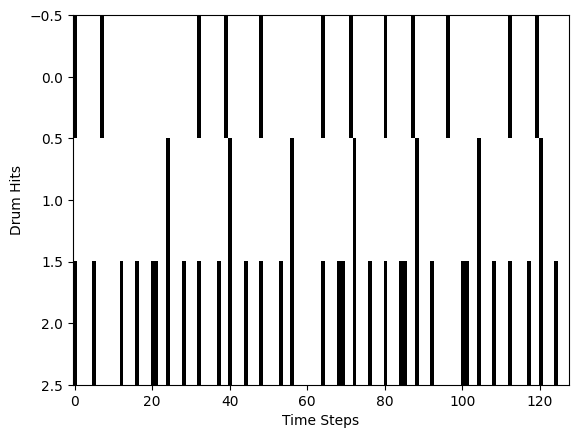

In [338]:
# Visualize a generated drum pattern
import matplotlib.pyplot as plt
plt.imshow(generated_sequence[0].T, cmap='binary', aspect='auto')
plt.xlabel('Time Steps')
plt.ylabel('Drum Hits')
plt.show()


In [339]:
# Evaluate on a test set
evaluation_results = model.evaluate(X_val, y_val)
test_loss = evaluation_results[0]  # Loss is always the first value
test_acc = evaluation_results[1]  # Accuracy is the second value (if defined in metrics)
test_prec = evaluation_results[2]
test_recall = evaluation_results[3]

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Precision: {test_prec:.2f}")
print(f"Test Recall: {test_acc:.2f}")


7/7 [==============================] - 0s 19ms/step - loss: 0.0074 - accuracy: 0.2661 - precision_4: 0.8662 - recall_4: 0.5178
Test Loss: 0.0074
Test Accuracy: 0.27
Test Precision: 0.87
Test Recall: 0.27


In [340]:
def rnn_to_midi(rnn_sequence, output_file, tempo=120, steps_per_quarter=4):
    """
    Converts a binary RNN sequence to a MIDI file.

    Args:
    - rnn_sequence (numpy array): Binary array of shape (sequence_length, num_drums).
                                  Each row is a timestep, each column is a drum hit (1=hit, 0=no hit).
    - output_file (str): Path to save the output MIDI file.
    - tempo (int): Tempo of the generated MIDI in BPM.
    - steps_per_quarter (int): Number of subdivisions per quarter note.
    """
    # Map drum types to MIDI pitches
    drum_mapping = [36, 38, 42]  # Kick (36), Snare (38), Hi-Hat (42)

    # Ensure dimensions match
    if rnn_sequence.shape[1] != len(drum_mapping):
        print(f"Adjusting rnn_sequence to match drum_mapping size: {len(drum_mapping)}")
        rnn_sequence = rnn_sequence[:, :len(drum_mapping)]

    # Create a PrettyMIDI object
    pm = pretty_midi.PrettyMIDI(resolution=960, initial_tempo=tempo)
    drum_instrument = pretty_midi.Instrument(program=0, is_drum=True)

    # Calculate duration of each step
    beats_per_minute = tempo
    seconds_per_beat = 60.0 / beats_per_minute
    seconds_per_step = seconds_per_beat / steps_per_quarter  # Each step duration

    # Convert the RNN sequence to MIDI notes
    for step_idx, step in enumerate(rnn_sequence):
        start_time = step_idx * seconds_per_step
        end_time = start_time + seconds_per_step
        for drum_idx, hit in enumerate(step):
            if np.any(hit):  # Check if the drum is hit
                note = pretty_midi.Note(
                    velocity=100,  # Adjust the intensity of the hit
                    pitch=drum_mapping[drum_idx],  # Map to corresponding MIDI pitch
                    start=start_time,
                    end=end_time
                )
                drum_instrument.notes.append(note)

    # Add the drum instrument to the MIDI object
    pm.instruments.append(drum_instrument)

    # Write the MIDI file
    pm.write(output_file)
    print(f"MIDI file saved to {output_file}")


In [341]:
# Verify sequence length
print("Generated Sequence Length:", generated_sequence.shape[1])

# Adjust the number of steps per quarter note
steps_per_quarter = 4  # Ensure this matches the MIDI resolution

# Save the sequence as a MIDI file
rnn_to_midi(generated_sequence[0], "rnn_generated_drums.mid", tempo=120, steps_per_quarter=steps_per_quarter)


Generated Sequence Length: 128
MIDI file saved to rnn_generated_drums.mid
